# Simple data fitting module to fit meson data using gv_lsqfit
### Uses gvar and lsqfit modules.

## Code that contains functions for meson spectroscopy
- [Functions](#funcs)
- [Fit1](#fit1)
- [Fit2](#fit2)

### Outline:



In [1]:
#!/usr/bin/env python
import psycopg2 as psycopg2
import sqlalchemy as sqla
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib notebook

from IPython.display import display

import gvar as gv
import lsqfit

import sys

<a id = 'funcs'></a>


## Effective mass:
- Standard formula: 
$$ m_{eff} (n_t) = ln \frac{C(n_t)}{C(n_t+1)} $$
- Corrected formula ( suggested by Evan Weinberg (BU)):
$$ m_{eff} (n_t) = Arccosh \left( \frac{C(n_t+1)+C(n_t-1)}{C(n_t)} \right) $$


In [2]:

def f_meff(all_dta,mode='normal'):
    temp=all_dta['y']

    if mode=='improved':
        X,Y=all_dta['x'][1:-1],np.arccosh((temp[:-2]+temp[2:])/(2.0*temp[1:-1]))
    else :
        X,Y=all_dta['x'][:-1],np.log(temp[:-1]/temp[1:])

#     print X,Y
    plt.figure()
    plt.errorbar(x=X,y=gv.mean(Y),yerr=gv.sdev(Y),color='b',marker='o')
    plt.ylabel('$m_{eff}$',rotation='horizontal',size=20)
    plt.xlabel('t')

# f_meff(all_dta,mode='improved')


In [3]:

def f_meson_fit(x,p):
    '''
    Fit Function for meson fit that performs cosh or sinh fits for s=+1,-1 respectively.
    For s=0, it does a simple exponential fit.
    Functional form : f(x) = a1* [ e^(-m1*t)+ s* e^{-m1*(L-t)}]
    '''
    a1,m1=p['a1'],p['m1']
    t=x['x']
    L,s=x['L'],x['s']
    return a1*(np.exp(-m1*t)+s*np.exp(-m1*(L-t)))


def f_make_p0(par):
    p0=par.copy()
    return p0

def f_make_xy_corr(corrs,L,s,tmax,tmin=3,equil=0,block_size=1):
    '''
    Function to create the dictionaries x and y and all_dta. These are used in the fit.
    x stores xdata with other parameters that never change ('s' and 'L')
    y stores ydata
    '''
    
    ### IMPORTANT : average with the entire data set to get covariance between points.
    corrs=gv.dataset.avg_data(gv.dataset.bin_data(corr_data[equil:],binsize=block_size))
    t_arr=np.arange(len(corrs))
    arr_cov=gv.evalcov(corrs)

    # Warning if covariance matrix is diagonal. Covariance it not being computed correctly by gvar.
    chk=np.allclose(np.diag(np.diag(arr_cov)),arr_cov)
    if chk:
        print "Warning! Covariance matrix is diagonal",arr_cov.shape

#     print arr_cov.shape
#     np.savetxt('cov_mat_gvar',arr_cov,delimiter='\t')
    
    all_dta={'x':t_arr,'y':corrs}
    
    # Choosing a smaller subset tmin-tmax to fit.
    size=len(all_dta['y'])
    assert tmax<size,"tmax %d cannot be greater than total range %d"%(tmax,size)
    assert ((tmax-tmin)<size),"Selected time range %d > Total range %d "%(tmax-tmin,size)
    
    x={'x':all_dta['x'][tmin:tmax],'s':s,'L':L}
    y={'y':all_dta['y'][tmin:tmax]}
    
    return all_dta,x,y


def f_fit_plot(x,y,all_dta,fit,error_band=False,semilog=False,full_data=True):
    '''
    Function for plotting data with the fit lines and error bands.
    For correlators, using a semi-log plot.
    full_data=True, plots the entire data and the best-fit in the fit region
    '''

    plt.figure()
    # Plots data points
    if full_data: # Plot all the correlators even those not used in the fit.
        plt.errorbar(x=all_dta['x'],y=gv.mean(all_dta['y']),yerr=gv.sdev(all_dta['y']),color='black',linestyle='None',marker='o')
    else:         # Plot the data points used in the fit
        plt.errorbar(x=x['x'],y=gv.mean(y['y']),yerr=gv.sdev(y['y']),linestyle='None',color='red',marker='s')
    
    # Plot the best fit line
    # # Using a finer grid to get a continuous curve.
    curvex=dict(x)
    curvex['x']=np.linspace(min(fit.x['x']),max(fit.x['x']),500)
    curvey=gv.mean(fit.fcn(curvex,fit.p))
    plt.plot(curvex['x'],curvey,color='blue')

    if error_band:
        obs_fit=gv.mean(fit.fcn(curvex,fit.p))
        err_fit=gv.sdev(fit.fcn(curvex,fit.p))  
        sigma=2.0
        plt.fill_between(curvex['x'],obs_fit-sigma*err_fit,obs_fit+sigma*err_fit,color='yellow') # providing an error band.

    if semilog: plt.semilogy()
    plt.ylabel('C(t)')
    plt.xlabel('t')
    plt.title("Plot")


def f_perform_fit(dta,x,y,L,verbose=True,plot=True,full_data=False,error_band=False,semilog=False):
    
    '''
    Function wrapper to perform correlator fit for mesons.
    Reads dictionary dta with x and y data.
    Performs both cosh and sinh fits.
    '''
    
    print "*****************************",'\n'
    
    # Performing meson fit

    p0=f_make_p0(par)
    fit = lsqfit.nonlinear_fit(data=(x, y['y']), fcn=f_func, p0=p0,extend=True,svdcut=1e-8)

    # Print the fit results
    if verbose:
        print f_func.__doc__.strip('\n').strip('  ') # Prints the functional form of fit function.
        print(fit.format(maxline=True)),"\n\n"
    else :
        print fit,"\n\n"

    # Plot fit
    if plot: 
        f_fit_plot(x,y,all_dta,fit,full_data=full_data,error_band=error_band,semilog=semilog)
        f_meff(all_dta,mode='improved')



### Important Gvar tricks:
- Bin data:  
dta=gv.dataset.bin_data(dta[-equil:],binsize=block_size) # equil, block_size needed
- Average data:   
avgs=gv.dataset.avg_data(dta)
- Covariance data:  
covs=gv.evalcov(avgs)

## Fit 1: Pion data from SU(4) project:   Cosh fit

<a id = 'fit1'></a>


### Extract data from file into dataframe


In [4]:

# Read file into dataframe 
data_dir='test_data_files/'
fname=data_dir+'pointpion_12_24_74_163856'
df_pointpion=pd.read_csv(fname,sep='\t').reset_index().drop('index',1)
# df_pointpion
df1=df_pointpion[:]
df1;
# number of rows= num of configurations
# number of columns = number of correlators. Extracted from first entry of dataframe.
n_row=df1.shape[0]
n_col=np.array(df1['corr_data_re'][0].strip('[').strip(']').split(',')).shape[0]

corr_data=np.zeros(shape=(n_row,n_col))
for count,i in enumerate(df1['corr_data_re'].values):
    j=np.array(i.strip('[').strip(']').split(',')).astype(np.float64)
    corr_data[count]=j



## Meson fits:
<a id ='meson fit'></a>


- 'POINTPION' and 'POINTRHO033' should have form A ($e^{-mt} \pm e^{-m(L -t)}$) (like cosh)
    - for P+A : $ L \rightarrow 2 N_t $

- 'POINTPS505' and 'POINT055' should have the same behavior with a negative sign (like sinh)


***************************** 

Fit Function for meson fit that performs cosh or sinh fits for s=+1,-1 respectively.
    For s=0, it does a simple exponential fit.
    Functional form : f(x) = a1* [ e^(-m1*t)+ s* e^{-m1*(L-t)}]

Least Square Fit (no prior):
  chi2/dof [dof] = 2.1 [7]    Q = 0.04    logGBF = None

Parameters:
             a1   57447 (1338)      [   1 +- inf ]  
             m1    0.9007 (24)      [ 0.4 +- inf ]  

Fit:
      key         y[key]      f(p)[key]
---------------------------------------
        0    271.7 (6.0)    258.4 (4.4)  **
        1    111.8 (2.8)    105.0 (1.8)  **
        2     45.8 (1.2)     42.68 (73)  **
        3     18.80 (55)     17.41 (31)  **
        4      7.88 (25)      7.23 (13)  **
        5      3.61 (11)     3.333 (66)  **
        6     2.414 (61)     2.324 (48)  *
        7     3.311 (80)     3.333 (66)  
        8      7.07 (18)      7.23 (13)  

Settings:
  svdcut/n = 1e-08/0    reltol/abstol = 0.0001/0*    (itns/time = 21/0.0)





<IPython.core.display.Javascript object>


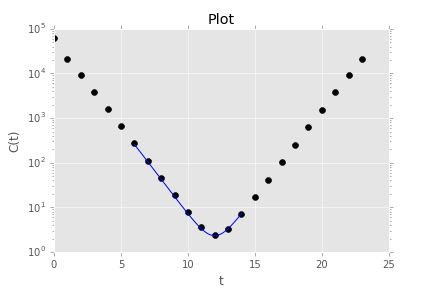

<IPython.core.display.Javascript object>


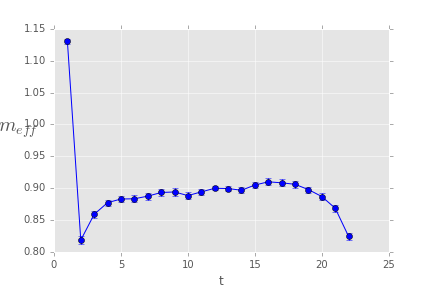

In [5]:
if __name__=='__main__' :
    f_func=f_meson_fit
    L,s=corr_data.shape[1],1
    tmin,tmax=6,15
    all_dta,x,y=f_make_xy_corr(corr_data,L,s,tmax=tmax,tmin=tmin,equil=0,block_size=1)
#     print x,y
    # Initial guesses for parameters.
    par={'a1':1,'m1':0.4}
    f_perform_fit(all_dta,x,y,L,verbose=True,plot=True,full_data=True,error_band=False,semilog=True)

----------------------------------------------------------------
----------------------------------------------------------------

## Fit 2: Fermion correlator fit using data from 4-fermion project :  Simple exponential fit.


<a id = 'fit2'></a>


Warning! Covariance matrix is diagonal (20, 20)
***************************** 

Fit Function for meson fit that performs cosh or sinh fits for s=+1,-1 respectively.
    For s=0, it does a simple exponential fit.
    Functional form : f(x) = a1* [ e^(-m1*t)+ s* e^{-m1*(L-t)}]

Least Square Fit (no prior):
  chi2/dof [dof] = 0.74 [9]    Q = 0.67    logGBF = None

Parameters:
             a1   0.00334 (13)      [ 0.01 +- inf ]  
             m1    0.6958 (76)      [  0.4 +- inf ]  

Fit:
      key             y[key]          f(p)[key]
-----------------------------------------------
        0    0.00005180 (79)    0.00005144 (76)  
        1    0.00002595 (55)    0.00002565 (52)  
        2    0.00001309 (39)    0.00001279 (34)  
        3       6.71(29)e-06       6.38(22)e-06  *
        4       3.45(21)e-06       3.18(13)e-06  *
        5       1.77(14)e-06      1.587(76)e-06  *
        6       8.81(84)e-07       7.91(44)e-07  *
        7       4.81(53)e-07       3.95(25)e-07  *
        8

<IPython.core.display.Javascript object>


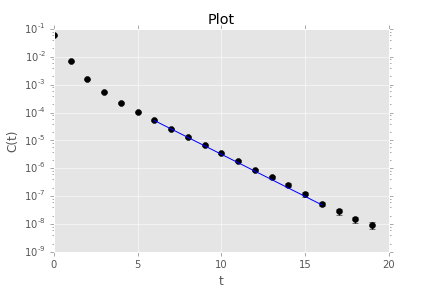

<IPython.core.display.Javascript object>


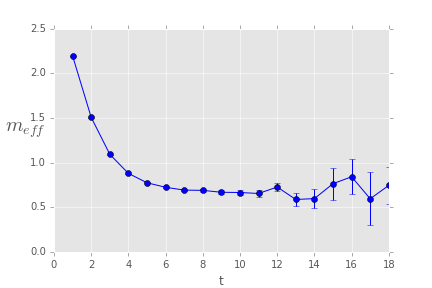

In [6]:
if __name__=='__main__' :
    # Read file.
    fname='test_data_files/covar_fit_test_data.txt'
    corr_data=np.loadtxt(fname)
    
    f_func=f_meson_fit
    L,s=corr_data.shape[1],0 ### Note, doing a simple exponential fit here.
    tmin,tmax=6,17
    all_dta,x,y=f_make_xy_corr(corr_data,L,s,tmax=tmax,tmin=tmin,equil=1000,block_size=50)
#     print x,y
    # Initial guesses for parameters.
    par={'a1':0.01,'m1':0.4}
    f_perform_fit(all_dta,x,y,L,verbose=True,plot=True,full_data=True,error_band=False,semilog=True)

Things to add:
- Add effective mass plot option to fit plot
- Add way to compute effective mass
- Add way to fold data